In [42]:
import sys
import os

sys.path.append(os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt

### Загрузка/Генерация данных

In [43]:
from recommender.data_generator import generate_synthetic_data

DATA_DIR = '../data'

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

users_path = os.path.join(DATA_DIR, 'users.csv')
products_path = os.path.join(DATA_DIR, 'products.csv')
ratings_path = os.path.join(DATA_DIR, 'ratings.csv')

if all(os.path.exists(p) for p in [users_path, products_path, ratings_path]):
    users = pd.read_csv(users_path)
    products = pd.read_csv(products_path)
    ratings = pd.read_csv(ratings_path)
else:
    users, products, ratings = generate_synthetic_data()
    users.to_csv(users_path, index=False)
    products.to_csv(products_path, index=False)
    ratings.to_csv(ratings_path, index=False)

display(users.head())
display(products.head())
display(ratings.head())

,user_id,age,income
0,0,23,129895
1,1,38,76513
2,2,42,50639
3,3,51,34112
4,4,58,74400


,product_id,type,interest_rate,term_months,min_income_required
0,0,deposit,14.255024,48,137957
1,1,credit_card,14.945163,24,30052
2,2,credit_card,8.050041,48,55889
3,3,deposit,3.807875,6,59242
4,4,credit_card,14.498641,24,86863


,user_id,product_id,rating
0,676,61,1
1,745,58,4
2,901,59,5
3,669,46,5
4,498,76,2


### train_test_split

In [44]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    ratings,
    test_size=0.2,
    random_state=42
)

train_df.shape, test_df.shape

((8000, 3), (2000, 3))

### Предобработка

In [45]:
from recommender.preprocessing import preprocess_products

product_features = preprocess_products(products)
product_features.head()

,product_id,interest_rate,term_months,min_income_required,type_deposit,type_insurance,type_loan
0,0,0.941802,1.000000,0.924340,True,False,False
1,1,1.000000,0.428571,0.062424,False,False,False
2,2,0.418546,1.000000,0.268803,False,False,False
3,3,0.060812,0.000000,0.295586,True,False,False
4,4,0.962346,0.428571,0.516215,False,False,False


### Инициализация и обучение моделей

In [46]:
from recommender.content_based import ContentRecommender
from recommender.collaborative import CollaborativeRecommender
from recommender.hybrid import HybridRecommender
from recommender.advanced_hybrid import AdvancedHybridRecommender
from recommender.matrix_factorization import SVDRecommender

content_model = ContentRecommender(product_features)

collab_model = CollaborativeRecommender(
    users,
    products,
    train_df
)
collab_model.train()

hybrid_model = HybridRecommender(
    collab_model=collab_model,
    content_model=content_model,
)

svd_model = SVDRecommender(train_df, n_factors=30)
svd_model.fit()

advanced_hybrid = AdvancedHybridRecommender(
    collab_model=collab_model,
    content_model=content_model,
    ratings_df=train_df,
    weight_strategy='adaptive',
    use_popularity=True
)

### Тест всех моделей

In [47]:
from recommender.evaluation import evaluate_model, catalog_coverage

K = 10
results = []

models = {
    "Collaborative": collab_model,
    "Content-based": content_model,
    "SVD": svd_model,
    "Hybrid (basic)": hybrid_model,
    "Hybrid (advanced)": advanced_hybrid
}

for name, model in models.items():
    metrics = evaluate_model(model, test_df, K)
    metrics["Model"] = name
    metrics["Coverage@K"] = catalog_coverage(
        model,
        users=test_df["user_id"].unique(),
        all_items=products["product_id"].unique(),
        k=K
    )
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("Model")
results_df

,Precision@K,Recall@K,NDCG@K,Inference Time (s),Coverage@K
Model,,,,,
Collaborative,0.023212,0.100246,0.054894,0.138199,1.0
Content-based,0.002462,0.009984,0.006027,0.070962,1.0
SVD,0.024619,0.107454,0.061468,0.074125,1.0
Hybrid (basic),0.023212,0.100246,0.054894,0.119504,1.0
Hybrid (advanced),0.021923,0.095330,0.053988,0.462309,1.0


# Визуализация

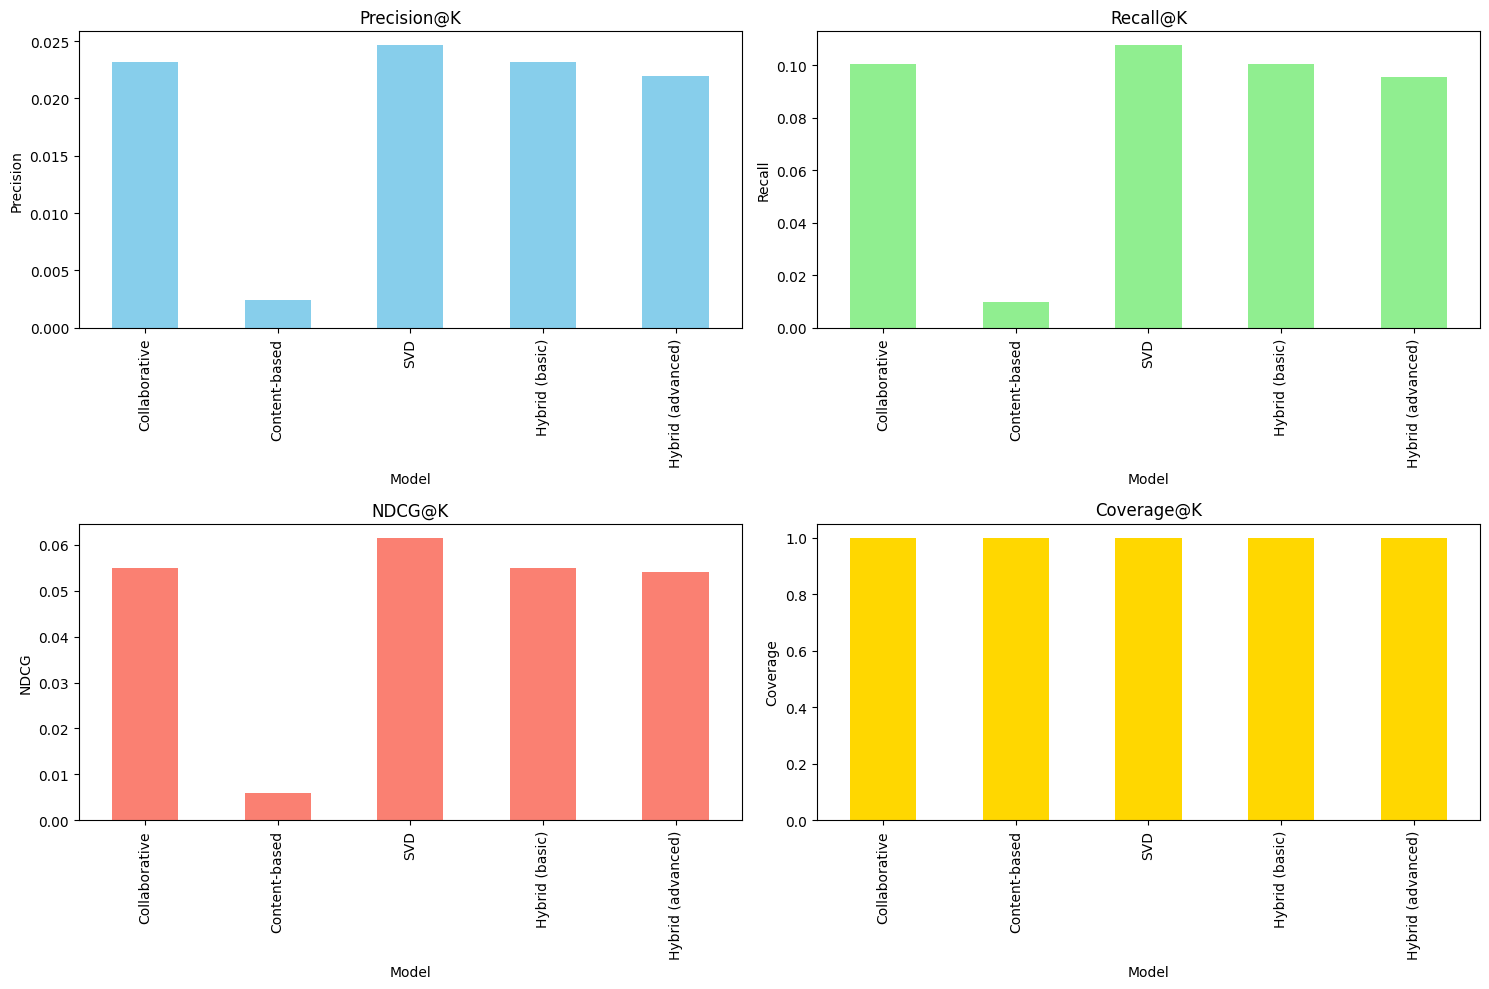

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision@K
results_df["Precision@K"].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Precision@K')
axes[0, 0].set_ylabel('Precision')

# Recall@K
results_df["Recall@K"].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Recall@K')
axes[0, 1].set_ylabel('Recall')

# NDCG@K
results_df["NDCG@K"].plot(kind='bar', ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('NDCG@K')
axes[1, 0].set_ylabel('NDCG')

# Coverage@K
results_df["Coverage@K"].plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Coverage@K')
axes[1, 1].set_ylabel('Coverage')

plt.tight_layout()
plt.show()

### Таблица сравнения

In [49]:
print("Сравнение моделей:")
display(results_df.sort_values('NDCG@K', ascending=False))

Сравнение моделей:


,Precision@K,Recall@K,NDCG@K,Inference Time (s),Coverage@K
Model,,,,,
SVD,0.024619,0.107454,0.061468,0.074125,1.0
Collaborative,0.023212,0.100246,0.054894,0.138199,1.0
Hybrid (basic),0.023212,0.100246,0.054894,0.119504,1.0
Hybrid (advanced),0.021923,0.095330,0.053988,0.462309,1.0
Content-based,0.002462,0.009984,0.006027,0.070962,1.0
